## Laboratorium 8.1


## Metody wykrywania ruchu: przepływ optyczny (_optical flow_)

### Wstęp

Na poprzednich laboratoriach poznaliśmy podstawowe metody przetwarzania obrazów, a więc dwuwymiarowych sygnałów przestrzennych. Jednak w praktyce czasami dysponujemy materiałem wideo, a więc sygnałami _trójwymiarowymi_, gdzie trzecim wymiarem jest czas. Oczywiście, można takie dane traktować jako po prostu sekwencję niezależnych obrazów - i wtedy działają wszystkie poznane dotychczas metody. Jednak dlaczego by nie wykorzystać tej dziedziny czasowej do przetwarzania sygnału? Intuicyjnie czujemy, że jeśli jakiś rejon obrazu przesunął się w czasie, to prawdopodobnie ma on inne _znaczenie_ niż rejon, który pozostał w tym samym miejscu, lub przesunął w innym kierunku czy z inną szybkością. Jeśli zatem jesteśmy w stanie wykryć to przesunięcie - czyli po prostu _ruch_ - to otrzymamy pewną informację o zawartości obrazu (wideo). Na przykład, będziemy w stanie oddzielić poruszające się obiekty od stacjonarnego tła, albo oddzielić inaczej poruszające się obiekty.

Najpowszechniejszą metodą do automatycznej detekcji ruchu jest metoda przepływu optycznego (ang. _optical flow_). Pominiemy w tej instrukcji matematyczne podstawy tej metody - te są wystarczająco dobrze wyłożone w [artykule z dokumentacji OpenCV](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html), do którego lektury namawiam\*. Wiedzieć należy na pewno, że istnieją dwie główne odmiany metody przepływu optycznego:,
* przepływ gęsty (_dense_) - gdzie przesunięcie pomiędzy klatkami określane jest dla każdego piksela (na tej metodzie skupia się niniejsza część listy),
* przepływ rzadki (_sparse_) - gdzie ruch wykrywany jest tylko dla pewnego zbioru punktów zainteresowania w obrębie obrazu (przebadasz ją w drugiej części listy).

W ramach obu odmian występuje pewna liczba konkretnych metod obliczeniowych, w zależności od konkretnego podejścia do rozwiązywania równania ruchu. Na tych zajęciach wykorzystamy [algorytm Farnebacka](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf) - głównie dlatego, że jego gotowa implementacja znajduje się w pakiecie OpenCV.

\* - Czytając, zwróć uwagę na podział na sekcje _Lucas-Kanade_ oraz _Dense Optical Flow_. Analizując kod metody, poświęć chwilę na zrozumienie mapowania wyników do prezentowanego obrazu w przestrzeni HSV.

### Podejście

Większość algorytmów optical flow operuje na parze klatek, znajdując translację pomiędzy jedną a drugą. Jeśli więc interesuje nas przetwarzanie ciągłego strumienia wideo, praca przebiegać będzie na zasadzie dwuelementowej kolejki, tzn. zawsze patrzymy na klatkę obecną i poprzednią.

OpenCV oferuje banalnie prosty a zarazem potężny interfejs do obsługi strumieni wideo: [`cv2.VideoCapture`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html), za pomocą którego w ten sam sposób możemy obsługiwać pliki wideo w różnym kodowaniu, urządzenia wideo (np. kamerkę w laptopie) czy nawet wideo w protokole IP (choć występują pewne różnice z punktu widzenia użycia, jeśli korzystamy z zasobu hardware'owego działającego w czasie rzeczywistym). Idea jest prosta:
* tworzymy obiekt `cv2.VideoCapture` w odpowiedni sposób,
* pobieramy poszczególne klatki za pomocą metody [`VideoCapture::read`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).

Metoda `read` wykonuje całą pracę (odczytanie danych, dekodowanie strumienia wideo) i zwraca klatkę jako obraz w standardowym formacie OpenCV (a także flagę, czy w ogóle udało się pozyskać dane - krotka (flaga, klatka)). Zatem, aby pozyskać pierwszą klatkę z pliku wideo wystarczy:
```python
vid = cv2.VideoCapture("back.mp4")
r, frame = vid.read()
```

Drobnym ograniczeniem VideoCapture jest to, że nie ma możliwości cofnięcia się do poprzednio pobranej klatki (co jest naturalne w przypadku korzystania z fizycznego urządzenia do akwizycji, a może trochę mniej gdy czytamy z pliku). Jeśli potrzebny jest powrót do początku pliku wideo, niestety konieczne jest zamknięcie strumienia (`VideoCapture::release`) i ponowne otwarcie (`::open`).

Aby obliczyć (gęsty) przepływ optyczny pomiędzy dwiema klatkami, wykorzystamy algorytm Farnebacka, zaimplementowany w OpenCV w funkcji [`cv2.calcOpticalFlowFarneback`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Przyjmuje ona parę obrazów **w skali szarości**, opcjonalny argument `flow` (rozwiązanie można zainicjować poprzednio wyliczonym przepływem, jeśli nim dysponujemy), a następnie szereg parametrów sterujących metodą; m.in. można wykorzystać piramidyzację obrazów (rekomendowane `pyr_size` $=3$) czy określić rozmiar okna detekcji `winsize`. Sensowne pierwsze wartości dla argumentów podane są w dokumentacji.

Algorytm Farnebacka zwraca przepływ w formie obrazu o wymiarach przestrzennych równych obrazom wejściowym i dwóch kanałach, zawierających przesunięcie odpowiednio w osi $x$ i $y$. Można więc przetwarzać te dane dalej, np. obliczając kąt przesunięcia czy całkowitą odległość (i dalej, np. określić prędkość ruchu) - vide np. `cv2.cartToPolar`.

---

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Zadanie 1

#### Zadanie 1a
Otwórz wideo `kick.mp4` lub `back.mp4` i pobierz kilka klatek. Przewiń do interesującego Cię momentu - tak, aby uzyskać dwie klatki, na których widać ruch (pro-tip: znając framerate materiału (~25fps) i czas, w którym rozpoczyna się interesujący fragment, możesz w pętli "skonsumować" odpowiednią ilość klatek).  
Wykorzystaj algorytm Farnebacka do obliczenia przepływu pomiędzy klatkami. Wynik zaprezentuj w postaci obrazu całkowitego przesunięcia. W zależności od wybranego momentu w wideo, możesz spodziewać się uzyskania wyraźnych obszarów.

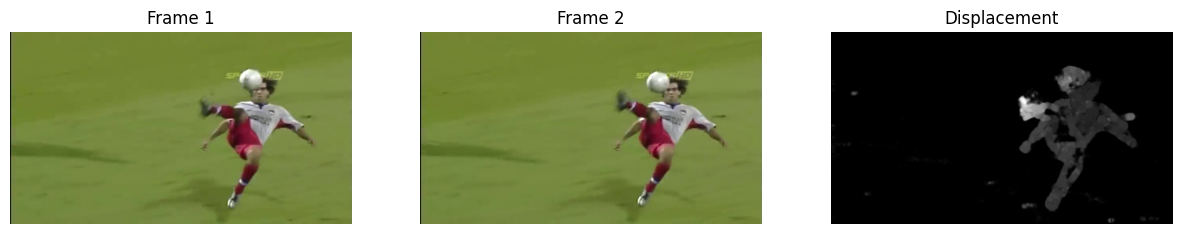

In [2]:
def read_frames(video_path, start_time=0, fps=25, frame_count=2):
    
    cap = cv2.VideoCapture(video_path)

    start_frame = int(start_time * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    frames = []
    frames_color=[]

    for _ in range(frame_count):
        ret, frame = cap.read()
        frames_color.append(frame)
        if not ret:
            break
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

    cap.release()
    return frames, frames_color

def calculate_optical_flow(frames):
    farneback_params = dict(
        pyr_scale=0.3, levels=3, winsize=15, iterations=3,
        poly_n=5, poly_sigma=1.2, flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN
    )

    flow = cv2.calcOpticalFlowFarneback(frames[0], frames[1], None, **farneback_params)
    return flow

def visualize_flow(flow, frames):
    magnitude, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # mask = np.zeros_like(frames[0])
    # mask[magnitude > 2] = 255
    return magnitude

video_path = 'kick.mp4' 
frames, frames_color = read_frames(video_path, start_time=1)  
flow = calculate_optical_flow(frames)
displacement_image = visualize_flow(flow, frames)

rgb_frame_0 = cv2.cvtColor(frames_color[0], cv2.COLOR_BGR2RGB)
rgb_frame_1 = cv2.cvtColor(frames_color[1], cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(rgb_frame_0)
plt.title('Frame 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(rgb_frame_1)
plt.title('Frame 2')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(displacement_image, cmap='gray')  
plt.title("Displacement")
plt.axis('off')
plt.show()

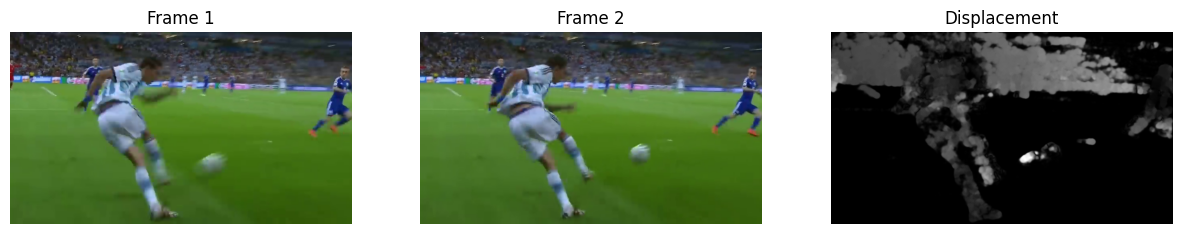

In [3]:
video_path = 'back.mp4' 
frames, frames_color = read_frames(video_path, start_time=1.25)  
flow = calculate_optical_flow(frames)
displacement_image = visualize_flow(flow, frames)

rgb_frame_0 = cv2.cvtColor(frames_color[0], cv2.COLOR_BGR2RGB)
rgb_frame_1 = cv2.cvtColor(frames_color[1], cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(rgb_frame_0)
plt.title('Frame 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(rgb_frame_1)
plt.title('Frame 2')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(displacement_image, cmap='gray')  
plt.title("Displacement")
plt.axis('off')
plt.show()

#### Zadanie 1b
Zbadaj wpływ parametru `winsize` na działanie metody.

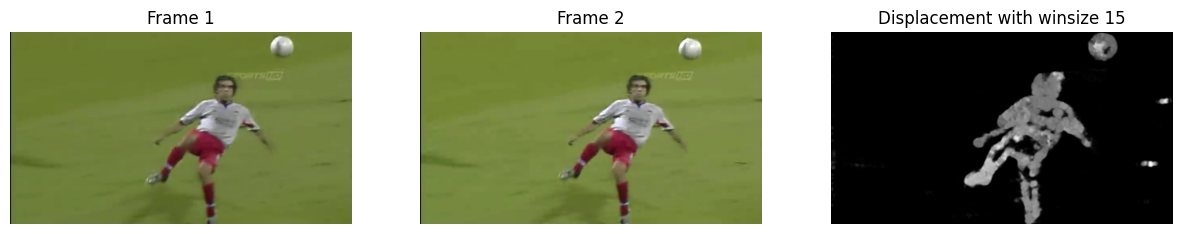

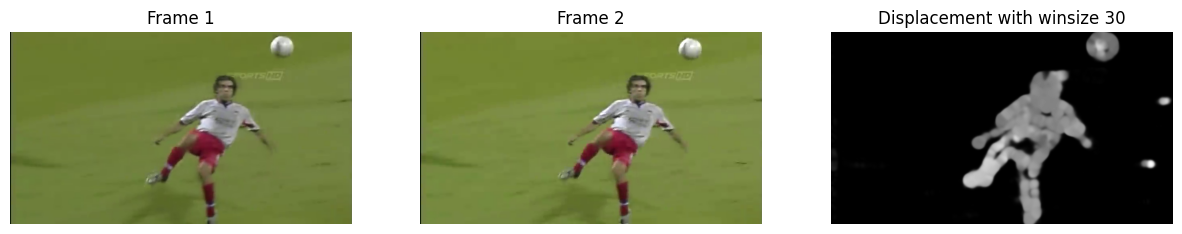

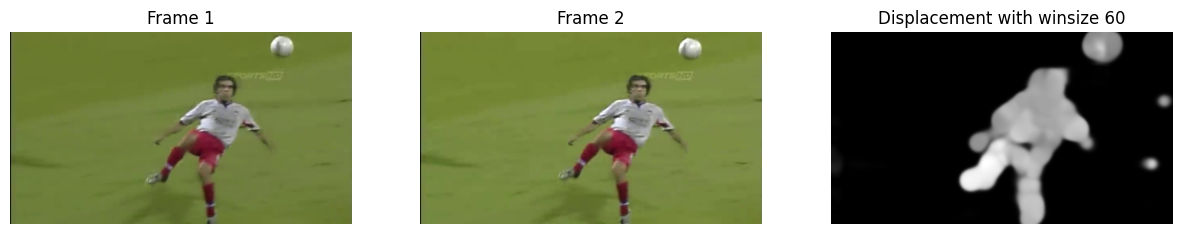

In [4]:
def calculate_optical_flow(frames, winsize):
    farneback_params = dict(
        pyr_scale=0.5, levels=3, winsize=winsize, iterations=3,
        poly_n=5, poly_sigma=1.2, flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN
    )

    flow = cv2.calcOpticalFlowFarneback(frames[0], frames[1], None, **farneback_params)
    return flow

winsize_values = [15, 30, 60]

video_path = 'kick.mp4'
frames, frames_color = read_frames(video_path, start_time=0.5)

rgb_frame_0 = cv2.cvtColor(frames_color[0], cv2.COLOR_BGR2RGB)
rgb_frame_1 = cv2.cvtColor(frames_color[1], cv2.COLOR_BGR2RGB)

for winsize in winsize_values:
    flow = calculate_optical_flow(frames, winsize)
    displacement_image = visualize_flow(flow, frames)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(rgb_frame_0)
    plt.title('Frame 1')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(rgb_frame_1)
    plt.title('Frame 2')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(displacement_image, cmap='gray')
    plt.title(f"Displacement with winsize {winsize}")
    plt.axis('off')
    plt.show()

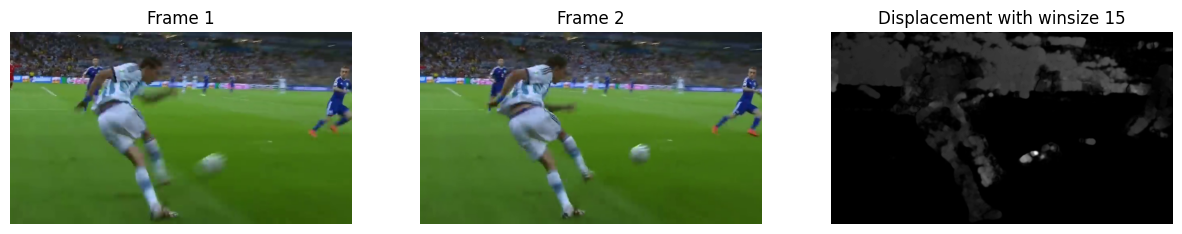

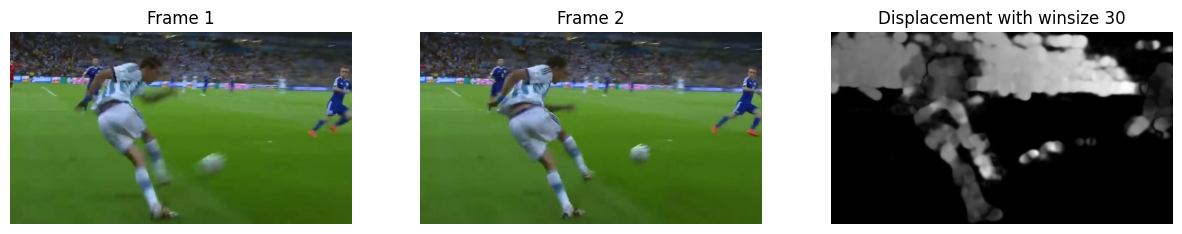

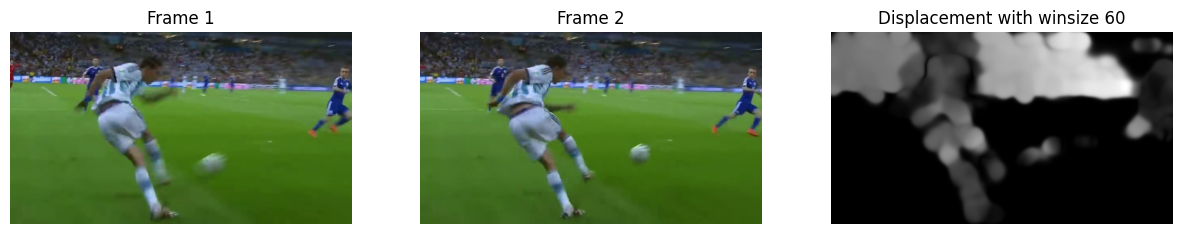

In [5]:
video_path = 'back.mp4'
frames, frames_color = read_frames(video_path, start_time=1.25)

rgb_frame_0 = cv2.cvtColor(frames_color[0], cv2.COLOR_BGR2RGB)
rgb_frame_1 = cv2.cvtColor(frames_color[1], cv2.COLOR_BGR2RGB)

for winsize in winsize_values:
    flow = calculate_optical_flow(frames, winsize)
    displacement_image = visualize_flow(flow, frames)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(rgb_frame_0)
    plt.title('Frame 1')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(rgb_frame_1)
    plt.title('Frame 2')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(displacement_image, cmap='gray')
    plt.title(f"Displacement with winsize {winsize}")
    plt.axis('off')
    plt.show()

Komentarz 1:

...

---

### Zadanie 2

Powtórz powyższy eksperyment na materiale `shot.mp4` (przewiń materiał do momentu natychmiast po uderzeniu białej bili, ok. 20-25 klatek; framerate wynosi tu ok. 15fps).  
*W czym leży trudność? Co jest ograniczeniem metody?*

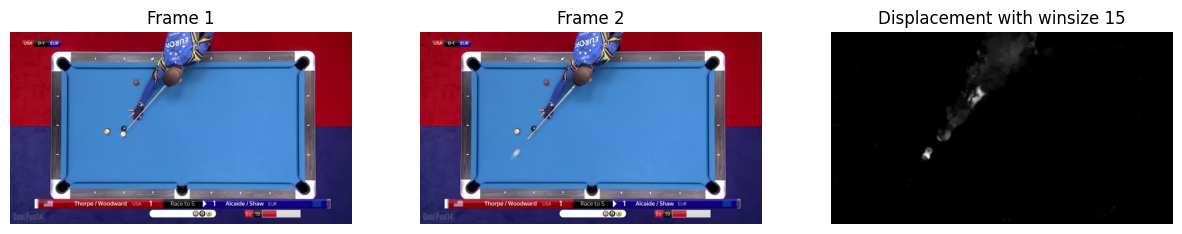

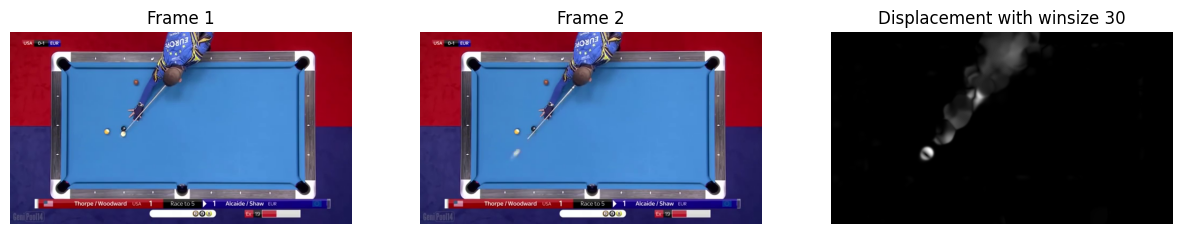

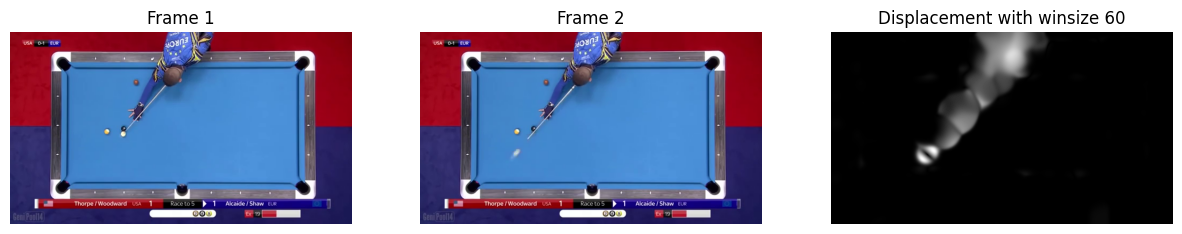

In [6]:
video_path = 'shot.mp4'
frames, frames_color = read_frames(video_path, start_time=0.83)

rgb_frame_0 = cv2.cvtColor(frames_color[0], cv2.COLOR_BGR2RGB)
rgb_frame_1 = cv2.cvtColor(frames_color[1], cv2.COLOR_BGR2RGB)

for winsize in winsize_values:
    flow = calculate_optical_flow(frames, winsize)
    displacement_image = visualize_flow(flow, frames)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(rgb_frame_0)
    plt.title('Frame 1')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(rgb_frame_1)
    plt.title('Frame 2')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(displacement_image, cmap='gray')
    plt.title(f"Displacement with winsize {winsize}")
    plt.axis('off')
    plt.show()

Komentarz 2:

...

### Zadanie dodatkowe

Powróć do takiego przypadku i konfiguracji algorytmu, dla którego uzyskane przez Ciebie wyniki były satysfakcjonujące. Przypomnij sobie zajęcia dotyczące np. segmentacji i wykorzystaj informację o przepływie optycznym do oddzielenia na obrazie obiektów od tła (metoda zupełnie dowolna).